# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Домашнее задание
1. Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). 

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

### 1. Импорты 

In [39]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GRU, Conv1D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### 2. Загрузка и подготовка данных

In [1]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2022-11-05 12:49:42--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 142.251.162.101, 142.251.162.138, 142.251.162.139, ...
Connecting to drive.google.com (drive.google.com)|142.251.162.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c39d598scoliqeoqqviln2v8ro2fosoc/1667652525000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=01b5400b-aa8c-40e1-b21e-c51eb0bbcf78 [following]
--2022-11-05 12:49:42--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c39d598scoliqeoqqviln2v8ro2fosoc/1667652525000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=01b5400b-aa8c-40e1-b21e-c51eb0bbcf78
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 74.125.28.132, 26

In [21]:
df = pd.read_csv('/content/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [22]:
df['Year'] = df.Month.apply(lambda x: x[:4])
df.Month = df.Month.apply(lambda x: x[5:])
df

,Month,Passengers,Year
0,01,112,1949
1,02,118,1949
2,03,132,1949
3,04,129,1949
4,05,121,1949
...,...,...,...
139,08,606,1960
140,09,508,1960
141,10,461,1960
142,11,390,1960


Разбиение на трейн и тест

In [24]:
train_size = 100


# список признаков, по которым будем учить
features = ['Year', 'Month', 'Passengers']
            
# отступ теста от тренировки
bias = 8


# делим
train_data = df.iloc[:train_size][features]
val_data = df.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (36, 3))

Стандартизация

In [28]:
features = train_data.columns[:2]
target = train_data.columns[2]
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data

,Year,Month,Passengers
0,-1.525724,-1.534863,112
1,-1.525724,-1.247435,118
2,-1.525724,-0.960008,132
3,-1.525724,-0.672580,129
4,-1.525724,-0.385153,121
...,...,...,...
95,1.376468,1.626840,306
96,1.791067,-1.534863,315
97,1.791067,-1.247435,301
98,1.791067,-0.960008,356


Формируем параметры для генерации выборки

In [44]:
# длина истории
x_len = 7

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.005
batch_size = 32
epochs = 100

In [31]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = df.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = df.iloc[label_start:][target].values

8 108
28 116


In [32]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (28, 2), (28,))

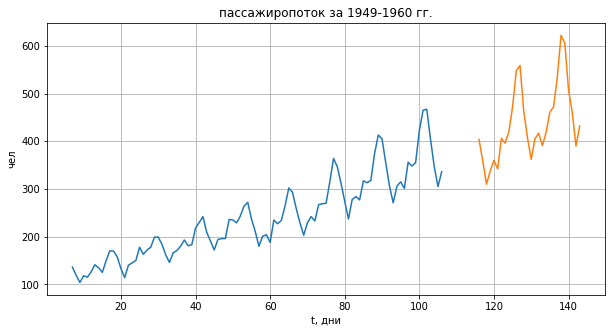

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(df.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(df.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('чел')
plt.title('пассажиропоток за 1949-1960 гг.')
plt.show()

In [36]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [37]:
for batch in dataset_train:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])
    break

Input shape: (32, 7, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]
 [-1.52572369 -0.38515289]
 [-1.52572369 -0.09772536]
 [-1.52572369  0.18970217]
 [-1.52572369  0.4771297 ]], shape=(7, 2), dtype=float64)
Target shape: (32,)
tf.Tensor(119, shape=(), dtype=int64)


### 3. Подготовка модели

Буду обучать модель: GRU слои + Conv1D + Dense слой

In [46]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)


model = Sequential()

model.add(GRU(64, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(Conv1D(128, 3, activation='linear'))
model.add(Conv1D(128, 1, activation='linear'))
model.add(Flatten())
model.add(Dense(64, activation='linear'))
model.add(Dense(1, activation='linear'))


model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 7, 64)             13056     
                                                                 
 gru_5 (GRU)                 (None, 7, 64)             24960     
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 128)            24704     
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 128)            16512     
                                                                 
 flatten_2 (Flatten)         (None, 640)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                41024     
                                                                 
 dense_5 (Dense)             (None, 1)                

### 4. Обучение модели

In [47]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/100
3/3 [==============================] - 5s 498ms/step - loss: 58484.8047 - mae: 229.7348 - val_loss: 182146.0469 - val_mae: 421.6422
Epoch 2/100
3/3 [==============================] - 0s 51ms/step - loss: 58195.5273 - mae: 229.0816 - val_loss: 181393.5156 - val_mae: 420.7581
Epoch 3/100
3/3 [==============================] - 0s 47ms/step - loss: 58019.9844 - mae: 228.7840 - val_loss: 180630.1719 - val_mae: 419.8606
Epoch 4/100
3/3 [==============================] - 0s 49ms/step - loss: 57663.4258 - mae: 228.1001 - val_loss: 179277.8438 - val_mae: 418.2639
Epoch 5/100
3/3 [==============================] - 0s 47ms/step - loss: 56818.1758 - mae: 226.4157 - val_loss: 176335.0156 - val_mae: 414.7644
Epoch 6/100
3/3 [==============================] - 0s 52ms/step - loss: 54842.2461 - mae: 222.3753 - val_loss: 169813.3906 - val_mae: 406.8957
Epoch 7/100
3/3 [==============================] - 0s 51ms/step - loss: 50445.7969 - mae: 213.0316 - val_loss: 155690.3438 - val_mae: 389.284

### 5. Визуализация работы модели

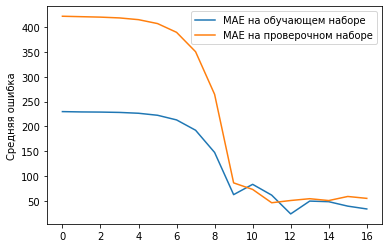

In [48]:
plt.plot(history.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [49]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

1/1 [==============================] - 0s 49ms/step


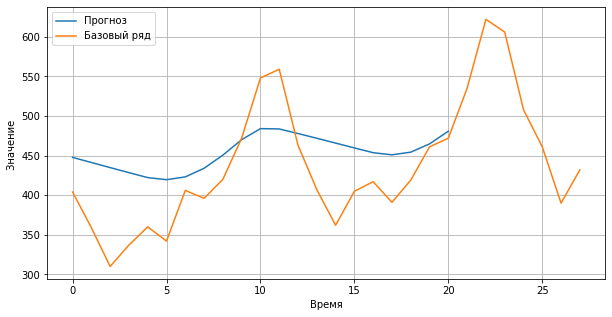

In [50]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

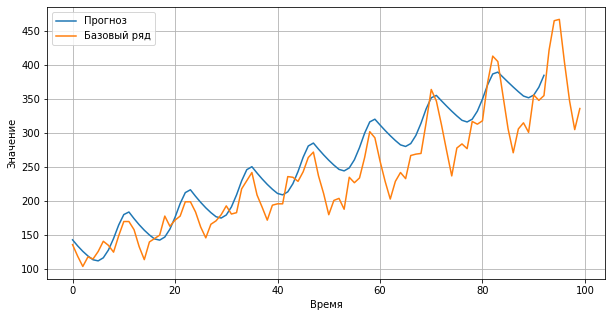

In [51]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

Ну что, вполне норм.

### 6. Выводы, анализ вариантов и всё такое

1. Для таких простых данных отлично подошла бы и классическая архитектура RNN, но поскольку этих данных мало, то и более сложные архитектуры будут иметь небольшое количество весов и быстро обучаться. Архитектура со слоями GRU выбрана, потому что показала хорошие метрики, не являясь избыточной, как LSTM.
2. GRU и LSTM необходимо минимум 15 эпох, чтобы нормально обучиться. Я выбрал вариант с callback - early stopping, чтобы не подбирать количество эпох вручную.
3. Оптимальный learning rate при такой архитектуре лежит в диапазоне примерно от 0,004 до 0,007. Я выбрал 0,005
4. Данные довольно однородны, нет значительной разницы между трейном и тестом. Если бы она была, возможно, следовало бы изменить/усложнить архитектуру.